In [40]:
from medmnist import BloodMNIST
import matplotlib.pyplot as plt
from torchvision import models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import VGG16_Weights
import cv2
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from PIL import Image

In [2]:
# Select device to accelerate the computation
#check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else device)

print(device)

mps


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = BloodMNIST(
    root='./datasets/', split='train', download=True, transform=transform)
val_dataset = BloodMNIST(root='./datasets/', split='val',
                         download=True, transform=transform)
test_dataset = BloodMNIST(root='./datasets/', split='test',
                          download=True, transform=transform)


# Data Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# get sample data
sample, label = train_dataset[0]
print(f"Lable: {label.item()}")
print(f"Image size: {sample.shape}")

Lable: 7
Image size: torch.Size([3, 224, 224])


In [5]:
def get_vgg16_model():
    # Load pre-trained VGG16 model
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)
    # Remove the existing classification head by replacing it
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),  # First fully connected layer (unchanged)
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 256),  # Replace second FC layer with smaller one
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 8),  # Binary classification (fracture vs. non-fracture)
        nn.Softmax(dim=1)  # Softmax for classification
    )
    return model

In [7]:
def to_rgb_image_np(gray_image_np):
    return np.dstack([gray_image_np, gray_image_np, gray_image_np])


def to_rgb_image_nps(gray_image_nps):
    for i in range(len(gray_image_nps)):
        gray_image_nps[i] = to_rgb_image_np(gray_image_nps[i])
    return gray_image_nps

In [9]:
def train(model, dataloader, optimizer=None, class_criterion=None):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader, desc="Training batch", leave=False):
        images = images.to(device)
        labels = labels.view(-1).long().to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = class_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


def validate(model, dataloader, class_criterion=None):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation batch", leave=False):
            images = images.to(device)
            labels = labels.view(-1).long().to(device)

            outputs = model(images)
            loss = class_criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(dataloader)


def test(model, dataloader, class_criterion=None):
    model.eval()
    y_true, y_pred = [], []
    running_loss = 0.0
    total_samples = 0
    show_sample = True

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing batch", leave=False):
            images = images.to(device)
            labels = labels.view(-1).long().to(device)

            outputs = model(images)
            loss = class_criterion(outputs, labels) if class_criterion else 0.0

            running_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

            if show_sample:
                count = 0
                # print the sample of misclassified images
                for i in range(len(labels)):
                    if labels[i] != outputs.argmax(dim=1)[i]:
                        print(
                            f"True: {labels[i].item()}, Predicted: {outputs.argmax(dim=1)[i].item()}")
                        plt.imshow(images[i].cpu().permute(1, 2, 0))
                        plt.show()
                        count += 1
                        if count == 3:
                            show_sample = False
                            break

    # 计算指标
    acc = accuracy_score(y_true, y_pred) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0)
    avg_loss = running_loss / total_samples if total_samples > 0 else 0.0

    print(f"Accuracy: {acc:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Average Loss: {avg_loss:.4f}")

    # 结果字典
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'loss': avg_loss
    }

In [9]:
# Train VGG16
# Use Cross-Entropy Loss and Adam optimizer.
model = get_vgg16_model()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 2
early_stop = 5
train_loss = []
val_loss = []
min_val_loss = np.inf
early_stop_counter = 0
best_model = None

# use tqdm for progress bar
for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
    # Train for one epoch
    train_loss_epoch = train(
        model, train_loader, optimizer, criterion)
    train_loss.append(train_loss_epoch)

    # Validate on validation set
    val_loss_epoch = validate(model, val_loader, criterion)
    val_loss.append(val_loss_epoch)

    # Early stopping logic
    if val_loss_epoch < min_val_loss:
        min_val_loss = val_loss_epoch
        early_stop_counter = 0
        best_model = model.state_dict()
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

# Plot the results
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training batch:   0%|          | 0/374 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# test model
model.load_state_dict(best_model)
model.eval()

# calculate accuracy, precision, recall, and F1 score
test(model, test_loader, criterion)

Testing batch:   0%|          | 0/107 [00:00<?, ?it/s]

Accuracy: 19.47%
Precision: 0.04
Recall: 0.19
F1 Score: 0.06
Average Loss: 2.0793


{'accuracy': 19.467991815258696,
 'precision': 0.037900270531897956,
 'recall': 0.19467991815258695,
 'f1_score': 0.06344840983098748,
 'loss': 2.0793288317872434}

In [37]:
def erosion(image):
    kernel = np.ones((3, 3), np.uint8)  # 3x3 结构元素
    return cv2.erode(image, kernel, iterations=1)

def skeletonization(image):
    skel = np.zeros(image.shape, np.uint8)  # 骨架结果初始化
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)  # 二值化
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))  # 交叉形结构元素
    done = False

    while not done:
        eroded = cv2.erode(image, element)  # 腐蚀
        temp = cv2.dilate(eroded, element)  # 先腐蚀再膨胀 (开运算)
        temp = cv2.subtract(image, temp)  # 提取去掉的部分
        skel = cv2.bitwise_or(skel, temp)  # 累加骨架
        image = eroded.copy()

        if cv2.countNonZero(image) == 0:  # 如果图像完全腐蚀完毕，停止
            done = True

    return skel

In [ ]:
class ErosionTransform:
    def __init__(self):
        pass

    def __call__(self, image):
        gray_image = image.convert("L")

        gray_image_np = np.array(gray_image)
        gray_image_np = cv2.erodes(
            gray_image_np, None, iterations=1)

        rgb_image_np = np.dstack(
            [gray_image_np, gray_image_np, gray_image_np])

        rgb_image = Image.fromarray(rgb_image_np)

        return rgb_image


class SkeletonizationTransform:
    def __init__(self):
        pass

    def __call__(self, image):
        gray_image = image.convert("L")

        gray_image_np = np.array(gray_image)
        gray_image_np = skeletonization(gray_image_np)

        rgb_image_np = np.dstack(
            [gray_image_np, gray_image_np, gray_image_np])

        rgb_image = Image.fromarray(rgb_image_np)

        return rgb_image

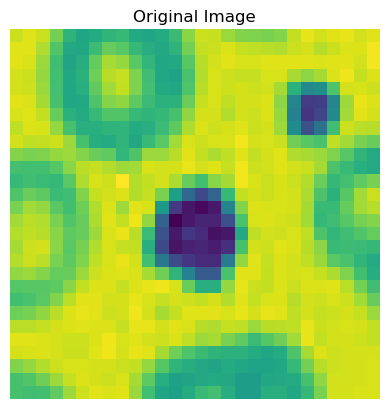

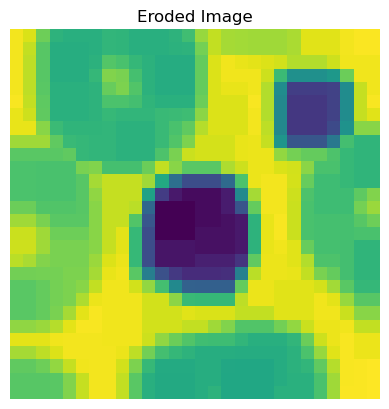

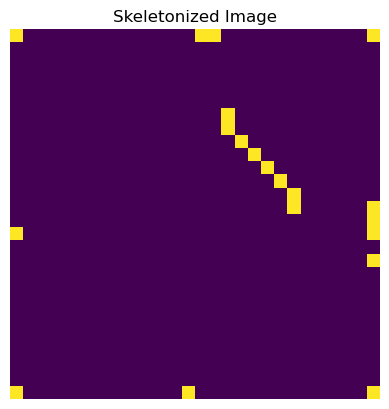

In [ ]:
train_dataset = BloodMNIST(
    root='./datasets/', split='train', download=True)
image, label = train_dataset[0]

gray_image = image.convert("L")
gray_image_np = np.array(gray_image)
plt.imshow(gray_image_np)
plt.axis('off')
plt.title("Original Image")
plt.show()

gray_image_np = erosion(gray_image_np)
plt.imshow(gray_image_np)
plt.axis('off')
plt.title("Eroded Image")
plt.show()

gray_image_np = np.array(gray_image)
gray_image_np = skeletonization(gray_image_np)
plt.imshow(gray_image_np)
plt.axis('off')
plt.title("Skeletonized Image")
plt.show()

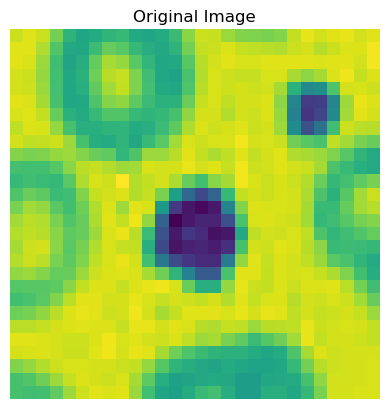

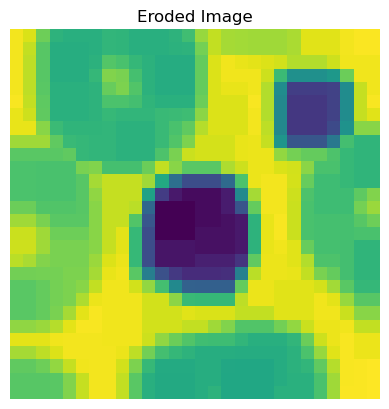

In [ ]:
trasnform = transforms.Compose([
    ErosionTransform(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = BloodMNIST(
    root='./datasets/', split='train', download=True, transform=transform)
val_dataset = BloodMNIST(root='./datasets/', split='val',
                         download=True, transform=transform)
test_dataset = BloodMNIST(root='./datasets/', split='test',
                          download=True, transform=transform)

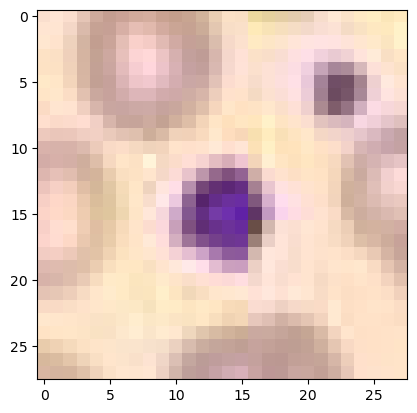

In [33]:
image, label = train_dataset[0]
plt.imshow(image)
plt.show()

In [ ]:
# Train VGG16
# Use Cross-Entropy Loss and Adam optimizer.
model = get_vgg16_model()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 2
early_stop = 5
train_loss = []
val_loss = []
min_val_loss = np.inf
early_stop_counter = 0
best_model = None

# use tqdm for progress bar
for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
    # Train for one epoch
    train_loss_epoch = train(
        model, train_loader, optimizer, criterion)
    train_loss.append(train_loss_epoch)

    # Validate on validation set
    val_loss_epoch = validate(model, val_loader, criterion)
    val_loss.append(val_loss_epoch)

    # Early stopping logic
    if val_loss_epoch < min_val_loss:
        min_val_loss = val_loss_epoch
        early_stop_counter = 0
        best_model = model.state_dict()
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

# Plot the results
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# test model
model.load_state_dict(best_model)
model.eval()

# calculate accuracy, precision, recall, and F1 score
test(model, test_loader, criterion)

In [ ]:
trasnform = transforms.Compose([
    transforms.Resize((224, 224)),
    SkeletonizationTransform(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = BloodMNIST(
    root='./datasets/', split='train', download=True, transform=transform)
val_dataset = BloodMNIST(root='./datasets/', split='val',
                         download=True, transform=transform)
test_dataset = BloodMNIST(root='./datasets/', split='test',
                          download=True, transform=transform)

In [ ]:
# Train VGG16
# Use Cross-Entropy Loss and Adam optimizer.
model = get_vgg16_model()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 2
early_stop = 5
train_loss = []
val_loss = []
min_val_loss = np.inf
early_stop_counter = 0
best_model = None

# use tqdm for progress bar
for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
    # Train for one epoch
    train_loss_epoch = train(
        model, train_loader, optimizer, criterion)
    train_loss.append(train_loss_epoch)

    # Validate on validation set
    val_loss_epoch = validate(model, val_loader, criterion)
    val_loss.append(val_loss_epoch)

    # Early stopping logic
    if val_loss_epoch < min_val_loss:
        min_val_loss = val_loss_epoch
        early_stop_counter = 0
        best_model = model.state_dict()
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

# Plot the results
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# test model
model.load_state_dict(best_model)
model.eval()

# calculate accuracy, precision, recall, and F1 score
test(model, test_loader, criterion)